In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pyplot as plt

# Import the backtrader platform
import backtrader as bt

# 编写交易策略

In [ ]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = ( 
        # 均线参数设置15天，15日均线  
        ('maperiod', 5), 
        )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self): 
        # 保存收盘价的引用  
        self.dataclose = self.datas[0].close 
        # 跟踪挂单  
        self.order = None 
        # 买入价格和手续费  
        self.buyprice = None 
        self.buycomm = None 
        # 加入均线指标  
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod) 


    # 订单状态通知，买入卖出都是下单  
    def notify_order(self, order): 
        if order.status in [order.Submitted, order.Accepted]: 
            # broker 提交/接受了，买/卖订单则什么都不做  
            return 
        # 检查一个订单是否完成  
        # 注意: 当资金不足时，broker会拒绝订单  
        if order.status in [order.Completed]: 
            if order.isbuy(): 
                self.log( 
                    '已买入, 价格: %.2f, 费用: %.2f, 佣金 %.2f' % 
                    (order.executed.price, 
                    order.executed.value, 
                    order.executed.comm)) 
                self.buyprice = order.executed.price 
                self.buycomm = order.executed.comm 
            elif order.issell(): 
                self.log('已卖出, 价格: %.2f, 费用: %.2f, 佣金 %.2f' % 
                    (order.executed.price, 
                    order.executed.value, 
                    order.executed.comm)) 

            # 记录当前交易数量  
            self.bar_executed = len(self) 
        elif order.status in [order.Canceled, order.Margin, order.Rejected]: 
            self.log('订单取消/保证金不足/拒绝')
        # 其他状态记录为：无挂起订单  
        self.order = None

    # 交易状态通知，一买一卖算交易  
    def notify_trade(self, trade): 
        if not trade.isclosed: 
            return 
        self.log('交易利润, 毛利润 %.2f, 净利润 %.2f' % 
        (trade.pnl, trade.pnlcomm)) 

    def next(self): 
        # 记录收盘价  
        self.log('Close, %.2f' % self.dataclose[0]) 

        # 如果有订单正在挂起，不操作  
        if self.order: 
            return 

        # 如果没有持仓则买入  
        if not self.position: 
            # 今天的收盘价在均线价格之上  
            if self.dataclose[0] > self.sma[0]: 
                # 买入  
                self.log('买入单, %.2f' % self.dataclose[0]) 
                # 跟踪订单避免重复  
                self.order = self.buy() 
        else: 
            # 如果已经持仓，收盘价在均线价格之下  
            if self.dataclose[0] < self.sma[0]: 
                # 全部卖出  
                self.log('卖出单, %.2f' % self.dataclose[0]) 
                # 跟踪订单避免重复  
                self.order = self.sell()

# 导入回测数据

In [3]:
# get data from AKShare
import akshare as ak
import pandas as pd

def get_data_from_akshare(symbol="QQQ", adjust="qfq"):
    data = ak.stock_us_daily(symbol=symbol, adjust=adjust).iloc[:,:7]
    # 把 date 作为日期索引，以符合 Backtrader 的要求
    data.index = pd.to_datetime(data['date'])
    return data

In [4]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Create a Data Feed
## load daily data from AKShare
stock_id = 'QQQ'
start_date = datetime.datetime(2024, 1, 1)  # 回测开始时间
end_date = datetime.datetime(2024, 12, 31)  # 回测结束时间
stock_qfq_df = get_data_from_akshare(symbol=stock_id)
## load data
data = bt.feeds.PandasData(dataname=stock_qfq_df, fromdate=start_date, 
                           todate=end_date, datetime='date', open='open', 
                           high='high',low='low', close='close', volume='volume')

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# 设置交易手续费

In [5]:
# 设置佣金
## IKBR pro用户，阶梯收费，忽略监管费用，只考虑佣金、交易所费用、清算费用
class IBKRProCommission(bt.CommInfoBase):
    params = (
        ('stocklike', True),  # 股票模式
        ('commtype', bt.CommInfoBase.COMM_PERC),  # 百分比佣金
        ('percabs', False),  # commission以百分比形式表示
    )

    def _getcommission(self, size, price, pseudoexec):
        # 根据交易量计算佣金
        volume = abs(size) * price
        if abs(size) <= 300000:
            commission_rate = 0.0035  # 0.35%
        elif abs(size) <= 3000000:
            commission_rate = 0.0020  # 0.20%
        elif abs(size) <= 20000000:
            commission_rate = 0.0015  # 0.15%
        elif abs(size) <= 100000000:
            commission_rate = 0.0010  # 0.10%
        else:
            commission_rate = 0.0005  # 0.05%

        commission = volume * commission_rate
        # 最多收取交易金额的1%
        commssion = min(commission, 0.001*volume)
        # 最少收取0.35美元
        commission = max(commission, 0.35)
        return commission

In [6]:
# 实例化自定义佣金类
ibkr_commission = IBKRProCommission()
# 添加到经纪商
cerebro.broker.addcommissioninfo(ibkr_commission, name='IBKRPro')

# 添加评测指标

In [7]:
# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益：日度收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率：日度收益
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 开始回测

In [8]:
# Set our desired cash start
cerebro.broker.setcash(1000.0)
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run over everything
result = cerebro.run()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00
2024-01-08, Close, 402.10
2024-01-08, 买入单, 402.10
2024-01-09, 已买入, 价格: 399.06, 费用: 399.06, 佣金 0.00
2024-01-09, Close, 402.90
2024-01-10, Close, 405.65
2024-01-11, Close, 406.50
2024-01-12, Close, 406.71
2024-01-16, Close, 406.67
2024-01-17, Close, 404.36
2024-01-17, 卖出单, 404.36
2024-01-18, 已卖出, 价格: 407.67, 费用: 399.06, 佣金 0.00
2024-01-18, 交易利润, 毛利润 8.61, 净利润 8.61
2024-01-18, Close, 410.14
2024-01-18, 买入单, 410.14
2024-01-19, 已买入, 价格: 412.37, 费用: 412.37, 佣金 0.00
2024-01-19, Close, 418.33
2024-01-22, Close, 418.88
2024-01-23, Close, 420.63
2024-01-24, Close, 422.98
2024-01-25, Close, 423.50
2024-01-26, Close, 420.96
2024-01-26, 卖出单, 420.96
2024-01-29, 已卖出, 价格: 421.42, 费用: 412.37, 佣金 0.00
2024-01-29, 交易利润, 毛利润 9.05, 净利润 9.05
2024-01-29, Close, 425.30
2024-01-29, 买入单, 425.30
2024-01-30, 已买入, 价格: 424.25, 费用: 424.25, 佣金 0.00
2024-01-30, Close, 422.45
2024-01-30, 卖出单, 422.45
2024-01-31, 已卖出, 价格: 418.00, 费用: 424.25, 佣金 0.00
2024-01-31, 交易利润, 毛利润 -6.25, 净利润 -6.25

# 策略评测及可视化

{'年化收益率（%）': 4.452680000000009, '最大回撤（%）': -3.9226456549738478, '年化夏普比率': None}


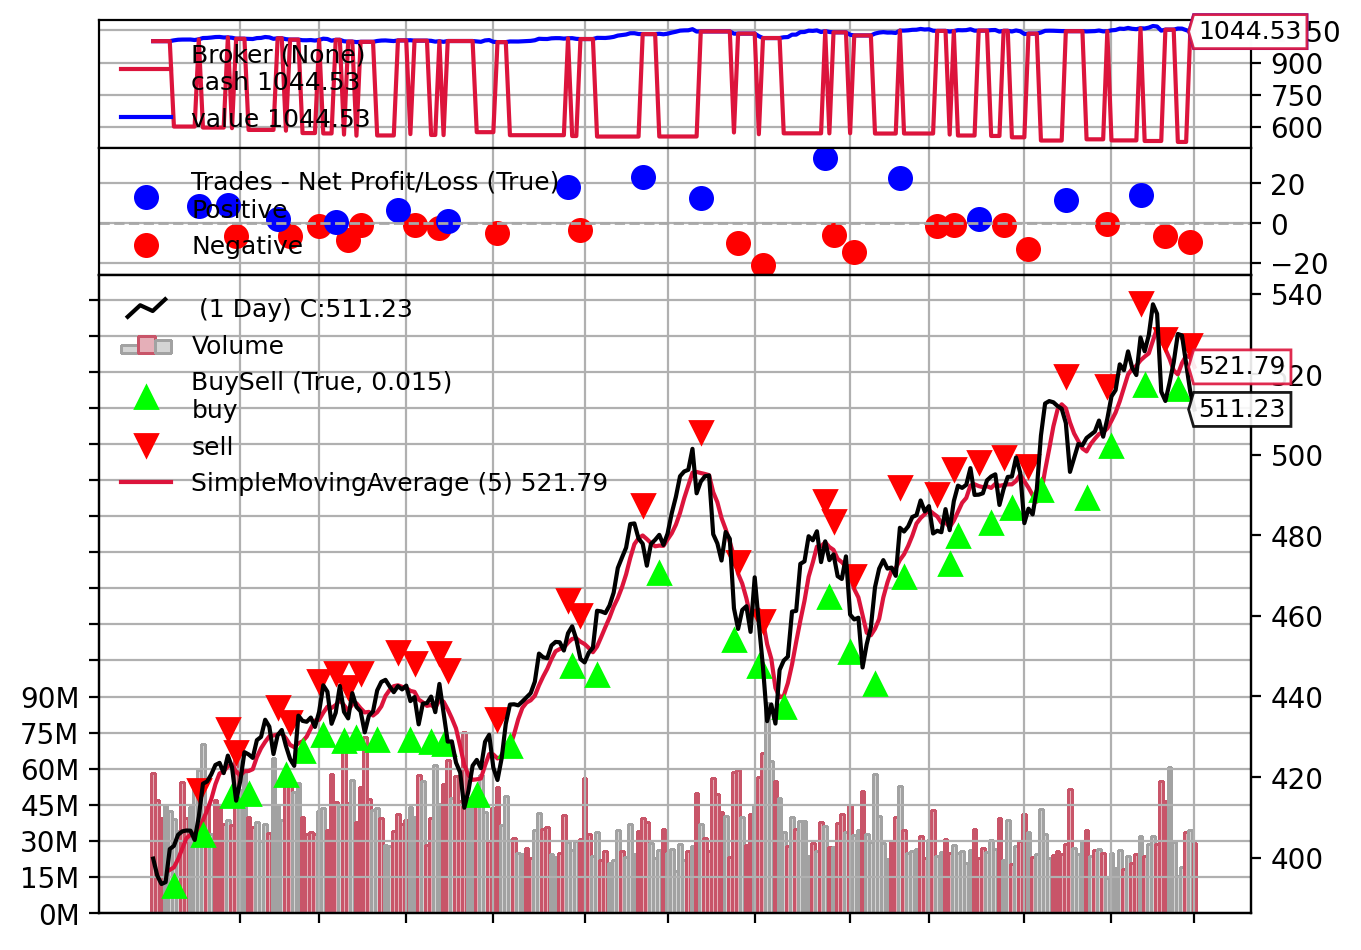

In [9]:
# 常用指标提取
analyzer = {}
# 提取年化收益
analyzer['年化收益率（%）'] = result[0].analyzers._Returns.get_analysis()['rnorm100']
# 提取最大回撤
analyzer['最大回撤（%）'] = result[0].analyzers._DrawDown.get_analysis()['max']['drawdown'] * (-1)
# 提取夏普比率
analyzer['年化夏普比率'] = result[0].analyzers._SharpeRatio_A.get_analysis()['sharperatio']
print(analyzer)

plt.clf()
%matplotlib inline
cerebro.plot(iplot=False)
plt.savefig('res.jpg')
plt.show()